# Moncton, New Brunswick Hotel Review Sentiment Analysis

# Data 

In [0]:
!pip install wget
import wget
!pip install twython
!pip install whoosh

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=8cce570d4c8467419d4f8508d432ec946338f90ee0d80be0f1488c95fbca447a
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 471kB 2.8MB/s 


In [0]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk
from whoosh import index, writing
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh.analysis import *
from whoosh.qparser import QueryParser

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
from nltk.tokenize import RegexpTokenizer

## Machine Learning
import sklearn
import sklearn.metrics as metrics

import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
random.seed(10)

####This dataset has already been cleaned. The step is completed in the 'da_filter_data.ipynb' file. There are 18 hotels in total with 120 reviews for 17 hotels and 100 reviews for the other one. The dataset has 2140 rows in total.

In [0]:
df = pd.read_csv('https://github.com/chuchu0428/Moncton_hotel_review_analysis/blob/master/reviews_moncton_cleaned.csv?raw=true', index_col=0)
df = df[['hotel','review','score','sentiment']]
pd.set_option('display.max_colwidth',-1)
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,hotel,review,score,sentiment
0,Amsterdam Inn &amp; Suites Moncton,"""This time, the first thing I noticed about this hotel is a young staff that was friendly, courteous, knowledgeable and helpful. One of the two best that I have ever encountered. We stayed in a front first floor room, which meant that we had an interior corridor, but also direct access to the outside and our car parked right in front of the room. The room itself was well above average, very clean, comfortable, nice bathroom. The (included) breakfast was quite good. We can't speak to the WiFi, as we hooked up to our own mobile unit.",4,positive
1,Amsterdam Inn &amp; Suites Moncton,"""I have no complaints about this hotel. While nothing really stood out as being exceptional, it was clean and comfortable. The service was OK, the breakfast was tasty with good selection for a continental, and while the location is somewhat out of the way, it's by no means inconvienent.\n\nThe price **may** have been a little high at $130\u002Fnight, however i've paid more for worse!\n\nRecommended.",4,positive
2,Amsterdam Inn &amp; Suites Moncton,"""hotel had all the items we needed for our stay including fridge, coffee maker and free breakfast and WIFI . Two minute walk to the casino for booked entertainment, or gambling at the casino. car necessary for all the great shopping in Moncton area. Great place to stay.",4,positive
3,Amsterdam Inn &amp; Suites Moncton,"""Navigating during this difficult time of covid-19 this hotel and their staff were nothing but Amazing. Welcoming with open arms but 6 feet away , their cleanliness to details and for the protection of their staff was exceptional. Their kindness goes beyond a 10\u002F10 rating ... They were simply amazing, accommodating, kind and compassionate ... We recommend them 10 times over and it was our first time meeting them and visiting this hotel in beautiful Moncton . Cathy needs a little star on her nametag, as she was a blessing to deal with . We cannot wait to book the beautiful honeymoon suite once our world returns to normal, and we can visit Moncton, and all it has to offer !",5,positive
4,Amsterdam Inn &amp; Suites Moncton,"""Our single room on the ground floor had an outside entrance with a cute little porch. This hotel has a lot of pros: convenient location (you don't have to drive hither and yon to find it from the highway), very clean rooms, super comfy bed, helpful & friendly front desk staff, breakfast included, strong wifi. Would definitely recommend.",5,positive


##Q1. Sentiment Analysis and Aggregation
###(a) Compute average Vader sentiment and average ground truth rating per hotel.

In [0]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence) #PMI(phrase,'excellent')-PMI(phrase,'poor')
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pandas.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [0]:
reviews = df['review'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])

100%|██████████| 2140/2140 [00:02<00:00, 872.98it/s]


In [0]:
reviewDF.head()

,reviewCol,vader
0,"""This time, the first thing I noticed about this hotel is a young staff that was friendly, courteous, knowledgeable and helpful. One of the two best that I have ever encountered. We stayed in a front first floor room, which meant that we had an interior corridor, but also direct access to the outside and our car parked right in front of the room. The room itself was well above average, very clean, comfortable, nice bathroom. The (included) breakfast was quite good. We can't speak to the WiFi, as we hooked up to our own mobile unit.",0.9789
1,"""I have no complaints about this hotel. While nothing really stood out as being exceptional, it was clean and comfortable. The service was OK, the breakfast was tasty with good selection for a continental, and while the location is somewhat out of the way, it's by no means inconvienent.\n\nThe price **may** have been a little high at $130\u002Fnight, however i've paid more for worse!\n\nRecommended.",0.7206
2,"""hotel had all the items we needed for our stay including fridge, coffee maker and free breakfast and WIFI . Two minute walk to the casino for booked entertainment, or gambling at the casino. car necessary for all the great shopping in Moncton area. Great place to stay.",0.9360
3,"""Navigating during this difficult time of covid-19 this hotel and their staff were nothing but Amazing. Welcoming with open arms but 6 feet away , their cleanliness to details and for the protection of their staff was exceptional. Their kindness goes beyond a 10\u002F10 rating ... They were simply amazing, accommodating, kind and compassionate ... We recommend them 10 times over and it was our first time meeting them and visiting this hotel in beautiful Moncton . Cathy needs a little star on her nametag, as she was a blessing to deal with . We cannot wait to book the beautiful honeymoon suite once our world returns to normal, and we can visit Moncton, and all it has to offer !",0.9855
4,"""Our single room on the ground floor had an outside entrance with a cute little porch. This hotel has a lot of pros: convenient location (you don't have to drive hither and yon to find it from the highway), very clean rooms, super comfy bed, helpful & friendly front desk staff, breakfast included, strong wifi. Would definitely recommend.",0.9740


In [0]:
df['vader'] = reviewDF['vader']
df2=df.copy()
df2['sentiment'] = [1 if x=='positive' else -1 for x in df.sentiment]

In [0]:
df2.head(1)

,hotel,review,score,sentiment,vader
0,Amsterdam Inn &amp; Suites Moncton,"""This time, the first thing I noticed about this hotel is a young staff that was friendly, courteous, knowledgeable and helpful. One of the two best that I have ever encountered. We stayed in a front first floor room, which meant that we had an interior corridor, but also direct access to the outside and our car parked right in front of the room. The room itself was well above average, very clean, comfortable, nice bathroom. The (included) breakfast was quite good. We can't speak to the WiFi, as we hooked up to our own mobile unit.",4,1,0.9789


In [0]:
print('The average Vader sentiment for each hotel is:')
print('\n')
df.groupby('hotel').mean().vader.sort_values(ascending=True)

The average Vader sentiment for each hotel is:




hotel
Howard Johnson by Wyndham Moncton                  0.344578
Travelodge Suites Moncton                          0.479580
Days Inn &amp; Suites by Wyndham Moncton           0.669666
Best Western Plus Moncton                          0.696138
Comfort Inn East                                   0.712707
Midtown Motel &amp; Suites                         0.770074
Rodd Moncton Hotel                                 0.772581
Crowne Plaza Moncton Downtown                      0.774815
Hotel Casino New Brunswick                         0.784327
V Hotel and Suites                                 0.790096
Four Points by Sheraton Moncton                    0.803104
Fairfield Inn &amp; Suites by Marriott Moncton     0.814950
Amsterdam Inn &amp; Suites Moncton                 0.816495
Delta Hotels by Marriott Beausejour                0.827642
Chateau Moncton Trademark Collection by Wyndham    0.852117
Residence Inn by Marriott Moncton                  0.873703
Hampton Inn &amp; Suites by Hilton

In [0]:
print('The average ground truth rating for each hotel is:')
print('\n')
df2.groupby('hotel').mean().sentiment.sort_values(ascending=False)

The average ground truth rating for each hotel is:




hotel
Hampton Inn &amp; Suites by Hilton Moncton         0.900000
Wild Rose Inn                                      0.850000
Residence Inn by Marriott Moncton                  0.850000
Fairfield Inn &amp; Suites by Marriott Moncton     0.850000
Four Points by Sheraton Moncton                    0.850000
Chateau Moncton Trademark Collection by Wyndham    0.800000
Amsterdam Inn &amp; Suites Moncton                 0.783333
Delta Hotels by Marriott Beausejour                0.616667
Midtown Motel &amp; Suites                         0.566667
Comfort Inn East                                   0.550000
Hotel Casino New Brunswick                         0.533333
Crowne Plaza Moncton Downtown                      0.466667
Rodd Moncton Hotel                                 0.450000
Best Western Plus Moncton                          0.433333
Days Inn &amp; Suites by Wyndham Moncton           0.283333
Travelodge Suites Moncton                          0.250000
V Hotel and Suites                

### (b) Rank hotels 


*   Average Ground Truth Sentiment





In [0]:
#top5
df2.groupby('hotel').mean()[['sentiment','vader']].sort_values(by=['sentiment'], ascending=False)[:5]

,sentiment,vader
hotel,,
Hampton Inn &amp; Suites by Hilton Moncton,0.90,0.877746
Fairfield Inn &amp; Suites by Marriott Moncton,0.85,0.814950
Residence Inn by Marriott Moncton,0.85,0.873703
Four Points by Sheraton Moncton,0.85,0.803104
Wild Rose Inn,0.85,0.940159


In [0]:
#bottom5
df2.groupby('hotel').mean()[['sentiment','vader']].sort_values(by=['sentiment'], ascending=True)[:5]

,sentiment,vader
hotel,,
Howard Johnson by Wyndham Moncton,-0.266667,0.344578
V Hotel and Suites,0.100000,0.790096
Travelodge Suites Moncton,0.250000,0.479580
Days Inn &amp; Suites by Wyndham Moncton,0.283333,0.669666
Best Western Plus Moncton,0.433333,0.696138


*   Average Vader Compound Sentiment Score

In [0]:
#top5
df2.groupby('hotel').mean()[['vader','sentiment']].sort_values(by=['vader'], ascending=False)[:5]

,vader,sentiment
hotel,,
Wild Rose Inn,0.940159,0.850000
Hampton Inn &amp; Suites by Hilton Moncton,0.877746,0.900000
Residence Inn by Marriott Moncton,0.873703,0.850000
Chateau Moncton Trademark Collection by Wyndham,0.852117,0.800000
Delta Hotels by Marriott Beausejour,0.827642,0.616667


In [0]:
#bottom5
df2.groupby('hotel').mean()[['vader','sentiment']].sort_values(by=['vader'], ascending=True)[:5]

,vader,sentiment
hotel,,
Howard Johnson by Wyndham Moncton,0.344578,-0.266667
Travelodge Suites Moncton,0.479580,0.250000
Days Inn &amp; Suites by Wyndham Moncton,0.669666,0.283333
Best Western Plus Moncton,0.696138,0.433333
Comfort Inn East,0.712707,0.550000


Top5 and bottom5 for both ranking methods generally agree with each other. Some interesting insights derived from this ranking are as follows:
*  Hampton Inn &amp; Suites by Hilton Moncton, Residence Inn by Marriott Moncton, and Wild Rose Inn had both high groud truth sentiment and high vader.
*  Howard Johnson by Wyndham Moncton, Travelodge Suites Moncton, Days Inn &amp; Suites by Wyndham Moncton, and Best Western Plus Moncton are associated with "poor" and negativity, reflected by both rankings. 

##Q2. Frequency Analysis
###(a) Use term frequency of the words for (i) positive reviews and (ii) negative with ground truth sentiment to rank the top-50 most frequent non-stopwords in the review collection. Do you note anything interesting and/or locale-specic about these top-ranked words?

In [0]:
def dataFrameTransformation(hotelDf, reviewDF, k=500):
    reviews = reviewDF['reviewCol'].values
    Filter = RegexTokenizer() | LowercaseFilter() | StopFilter() #| StemFilter()| IntraWordFilter() 
    stop = set(stopwords.words('english'))
    
    # Top-k frequent terms
    positiveCounter = Counter()
    negativeCounter = Counter()
    counter = Counter
    for i in range(len(reviews)): 
        if hotelDf['groundTruth'][i] ==1:
            positiveCounter.update([word.text for word in Filter(reviews[i]) 
                                    if len(word.text)>2 and word.text not in stop])
        else:
            negativeCounter.update([word.text for word in Filter(reviews[i]) 
                                    if len(word.text)>2 and word.text not in stop])
    topkPositive = positiveCounter.most_common(k)   #dictionary     
    topkNegative = negativeCounter.most_common(k)
    return topkPositive, topkNegative

In [0]:
df2.columns=['hotelName','hotelReview','ratingScore','groundTruth','vader']
topkPositive, topkNegative = dataFrameTransformation(df2, reviewDF, k=50)

In [0]:
topkPositive

[('room', 1553),
 ('hotel', 1515),
 ('breakfast', 1030),
 ('staff', 1004),
 ('great', 981),
 ('stay', 975),
 ('clean', 955),
 ('nice', 685),
 ('good', 685),
 ('moncton', 660),
 ('friendly', 631),
 ('stayed', 617),
 ('rooms', 608),
 ('comfortable', 607),
 ('would', 569),
 ('well', 445),
 ('one', 404),
 ('night', 384),
 ('location', 380),
 ('area', 379),
 ('place', 374),
 ('pool', 368),
 ('bed', 342),
 ('helpful', 333),
 ('free', 324),
 ('service', 321),
 ('time', 316),
 ('also', 295),
 ('close', 289),
 ('nthe', 288),
 ('desk', 285),
 ('inn', 275),
 ('beds', 270),
 ('hot', 269),
 ('front', 263),
 ('excellent', 253),
 ('really', 247),
 ('recommend', 245),
 ('downtown', 240),
 ('back', 238),
 ('check', 236),
 ('large', 228),
 ('quiet', 227),
 ('get', 222),
 ('parking', 218),
 ('right', 212),
 ('like', 210),
 ('always', 209),
 ('could', 208),
 ('casino', 203)]

In [0]:
topkNegative

[('room', 843),
 ('hotel', 535),
 ('would', 286),
 ('breakfast', 283),
 ('stay', 278),
 ('one', 253),
 ('night', 232),
 ('rooms', 218),
 ('clean', 216),
 ('good', 198),
 ('staff', 186),
 ('stayed', 186),
 ('like', 177),
 ('desk', 159),
 ('front', 155),
 ('nice', 151),
 ('get', 147),
 ('time', 138),
 ('bed', 135),
 ('could', 135),
 ('bathroom', 135),
 ('moncton', 132),
 ('pool', 132),
 ('great', 121),
 ('place', 118),
 ('check', 117),
 ('also', 116),
 ('people', 109),
 ('back', 108),
 ('small', 108),
 ('friendly', 100),
 ('said', 99),
 ('location', 96),
 ('well', 95),
 ('told', 91),
 ('next', 90),
 ('booked', 89),
 ('went', 87),
 ('nthe', 87),
 ('door', 86),
 ('beds', 86),
 ('even', 85),
 ('much', 85),
 ('got', 84),
 ('area', 84),
 ('floor', 82),
 ('price', 79),
 ('service', 79),
 ('two', 78),
 ('first', 78)]



*   "downtown" and "moncton" are highly ranked locale-specific terms for positive reviews. Other aspects of high frequency include breakfast, facilities like pool and casino, free services, staff etc. Terms featured in positive reviews are more frequent than those in negative reviews, possibly because there are more positive reviews than negative reviews in general.
*  "moncton" is also a highly ranked locale-specific term for negative reviews. Other aspects of high frequency include breakfast, amenities like bed, bathroom, floor etc.



###(b) Top 50 Noun Phrases

In [0]:
# Noun Phrase Extraction Support Functions
# from nltk.corpus import stopwords
from nltk.corpus import stopwords
stopword = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [0]:
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

# Create phrase tree
chunker = nltk.RegexpParser(grammar)
tagger = PerceptronTagger()
pos_tag = tagger.tag

In [0]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(hotelDf, reviewDF, k=50):
    reviews = reviewDF['hotelReview'].values
    
    # Top-k frequent terms
    counter = Counter()
    for review in tqdm(reviews):
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ])) #pos_tag() returns a list of tuple of term and syntax structure 
                                #chunker.parse() returns a tree
                                #get_terms returns item once a time to get two_word, three_word.. terms
                                #flatten make all terms into a list of two_word, three_word.. terms
    topk = counter.most_common(k)    
       
    return topk

In [0]:
positiveDf = df2[df2['groundTruth']==1]
negativeDf = df2[df2['groundTruth']==-1]

In [0]:
positiveDf.head(3)

,hotelName,hotelReview,ratingScore,groundTruth,vader
0,Amsterdam Inn &amp; Suites Moncton,"""This time, the first thing I noticed about this hotel is a young staff that was friendly, courteous, knowledgeable and helpful. One of the two best that I have ever encountered. We stayed in a front first floor room, which meant that we had an interior corridor, but also direct access to the outside and our car parked right in front of the room. The room itself was well above average, very clean, comfortable, nice bathroom. The (included) breakfast was quite good. We can't speak to the WiFi, as we hooked up to our own mobile unit.",4,1,0.9789
1,Amsterdam Inn &amp; Suites Moncton,"""I have no complaints about this hotel. While nothing really stood out as being exceptional, it was clean and comfortable. The service was OK, the breakfast was tasty with good selection for a continental, and while the location is somewhat out of the way, it's by no means inconvienent.\n\nThe price **may** have been a little high at $130\u002Fnight, however i've paid more for worse!\n\nRecommended.",4,1,0.7206
2,Amsterdam Inn &amp; Suites Moncton,"""hotel had all the items we needed for our stay including fridge, coffee maker and free breakfast and WIFI . Two minute walk to the casino for booked entertainment, or gambling at the casino. car necessary for all the great shopping in Moncton area. Great place to stay.",4,1,0.9360


In [0]:
topkNPPositive = newDataFrameTransformation(positiveDf, positiveDf, k=50)
topkNPNegative = newDataFrameTransformation(negativeDf, negativeDf, k=50)

100%|██████████| 479/479 [00:03<00:00, 128.74it/s]


In [0]:
topkNPPositive

[('front desk', 98),
 ('hot tub', 47),
 ('front desk staff', 45),
 ('first time', 41),
 ('great place', 41),
 ('free breakfast', 39),
 ('continent breakfast', 36),
 ('main street', 34),
 ('downtown moncton', 34),
 ('nthe room', 32),
 ('great locat', 32),
 ('great stay', 31),
 ('friendli staff', 30),
 ('pool area', 28),
 ('tidal bore', 28),
 ('comfort bed', 28),
 ('next time', 25),
 ('hot breakfast', 24),
 ('park lot', 23),
 ('water slide', 23),
 ('amsterdam inn', 22),
 ('breakfast area', 22),
 ('moncton area', 21),
 ('great hotel', 21),
 ('comfort room', 21),
 ('good valu', 20),
 ('hopewel rock', 20),
 ('crown plaza', 20),
 ('clean bed', 19),
 ('hotel staff', 19),
 ('nice place', 19),
 ('long day', 19),
 ('great experi', 18),
 ('breakfast buffet', 18),
 ('good breakfast', 18),
 ('night stay', 18),
 ('midtown motel', 18),
 ('new brunswick', 17),
 ('nthe staff', 17),
 ('minut drive', 17),
 ('chateau moncton', 17),
 ('futur inn', 17),
 ('good locat', 16),
 ('nthe hotel', 16),
 ('comfort i

In [0]:
topkNPNegative

[('front desk', 77),
 ('hot tub', 20),
 ('park lot', 17),
 ('free breakfast', 14),
 ('pool area', 13),
 ('next morn', 12),
 ('night stay', 11),
 ('main street', 11),
 ('nthe room', 10),
 ('doubl bed', 9),
 ('front desk staff', 9),
 ('cigarett smoke', 9),
 ('crown plaza', 9),
 ('first time', 8),
 ('hot water', 8),
 ('credit card', 7),
 ('hot breakfast', 7),
 ('custom servic', 7),
 ('breakfast area', 7),
 ('bathroom floor', 7),
 ('room servic', 7),
 ('hotel room', 7),
 ('corpor rate', 7),
 ('queen bed', 7),
 ('howard johnson', 7),
 ('air condition', 7),
 ('second floor', 6),
 ('good locat', 6),
 ('next day', 6),
 ('first room', 6),
 ('earli check', 6),
 ('holiday inn', 6),
 ('next time', 6),
 ('long time', 5),
 ('amsterdam inn', 5),
 ('comfort bed', 5),
 ('king room', 5),
 ('first floor', 5),
 ('good hotel', 5),
 ('first night', 5),
 ('continent breakfast', 5),
 ('front counter', 5),
 ('busi trip', 5),
 ('mini fridg', 5),
 ('clean staff', 5),
 ('nice hotel', 5),
 ('last night', 5),
 ('ch

*  Noun phrase is more informative than a single word.Locale-specific terms for positive reviews include "downtown Moncton", "main street", "crown plaza", "chateau moncton", "hopewel rock", etc. Positive reviews are associated with good breakfast, good amenities, and location close to areas of high traffic.
*  Locale_specific terms for negative reviews have overlaps with positive reviews, including "main street" and "crown plaza". Negative reviews are associated with basic amenities, basic breakfast, etc.



##Q3. Mutual Information
###(a) Use mutual information (MI) with ground truth sentiment to rank the top-50 most sentiment-bearing non-stopwords in the review collection. Do you note anything interesting and/or locale-specic about these top-ranked words?

In [0]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
from nltk.corpus import stopwords
def dataFrameTransformation(hotelDf, reviewDF, k=500):
    reviews = reviewDF['reviewCol'].values
    
    stop = set(stopwords.words('english'))
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) #non-alphanumerical
                            if word.lower() not in stop and len(word) > 2]) 
    topk = counter.most_common(k)  #re.finalleturn all non-overlapping matches of pattern in string, as a list of strings.
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk] #if this review has topk word 
        freqReview.append(topkinReview) #number of reviews*k
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf) #review, vader, freqReview
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf) #hotelName','ratingScore','groundTruth', review, vader, freqReview
    return topk, finaldf

# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'): 
    miScore = []
    for word in topk: #mutual information between groundtruth sentiment for all reviews and each review' involvement with the word
        miScore.append([word[0]]+[metrics.mutual_info_score(finaldf[label_column], finaldf[word[0]])]) #[the word]+[mutual(array_of_grountruth,array_of_freqReview)]
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0) #by column 1 
    miScoredf.columns = ['Word','MI Score'] 
    return miScoredf

In [0]:
# Revise the previous dataframe transform function...
def newDataFrameTransformationNP(hotelDf, reviewDF, k=50):
    reviews = reviewDF['reviewCol'].values
    
    # Top-k frequent terms
    counter = Counter()
    for review in tqdm(reviews):
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ])) #pos_tag() returns a list of tuple of term and syntax structure 
                                #chunker.parse() returns a tree
                                #get_terms returns item once a time to get two_word, three_word.. terms
                                #flatten make all terms into a list of two_word, three_word.. terms
    topk = counter.most_common(k)    

        #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'): 
    miScore = []
    for word in topk: #mutual information between groundtruth sentiment for all reviews and each review' involvement with the word
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])]) #[the word]+[mutual(array_of_grountruth,array_of_freqReview)]
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0) #by column 1 
    miScoredf.columns = ['Word','MI Score'] 
    return miScoredf

In [0]:
topk, finaldf = dataFrameTransformation(df2, reviewDF, k=50)
topkNP, finaldfNP = newDataFrameTransformationNP(df2, reviewDF, k=50)

100%|██████████| 2140/2140 [00:12<00:00, 172.56it/s]


In [0]:
miScoredf = getMI(topk, finaldf)
miScoredf

,Word,MI Score
6,great,0.016858
42,bathroom,0.015915
14,comfortable,0.014262
4,staff,0.011600
0,room,0.011551
16,night,0.010809
29,like,0.009891
13,friendly,0.009530
47,excellent,0.009423
32,get,0.008864


*  Mutual Information represents the relationship between the occurrence of the word (for each review whether the word exists or not) and the groud truth sentiment (positive or negative). The greater the value, the more representative/informative of the ground truth sentiment the word is. 
*  Locale-specific words are "downtown" and "moncton". 
*  Basic amenities like bathroom, room can tell you a lot. Adjectives like "comfortable", "great", "friendly", "excellent", etc. can also tell you a lot about ground truth sentiment.

###(b) Mutual Information for Noun Phrase

In [0]:
miScoredf = getMI(topkNP, finaldfNP)
pd.set_option('display.float_format', lambda x: '%.6f' % x)
miScoredf

,Word,MI Score
0,front desk,0.006059
7,great place,0.003391
35,comfort room,0.002500
47,nice place,0.002261
23,next morn,0.001871
20,tidal bore,0.001795
10,park lot,0.001747
14,great stay,0.001562
29,great hotel,0.001295
11,downtown moncton,0.001118


*  The value of mutual information for noun phrases is smaller than that for words, possibly because the occurrence of the phrase in each review is much fewer. The phrase is not as representative of the ground truth sentiment as the word because the phrase is rarer to be found in reviews.
* Locale-specific phrases are "crown plaza", "hopewel rock", and "moncton area", and "new brunswick".
* Breakfast can tell us a lot about ground truth sentiment.

##Q4. PMI
###(a) For ground truth sentiment, calculate the top-50 words according to PMI of the word occuring with (i) positive reviews and (ii) negative reviews. Do you note anything interesting and/or locale-specic about these top-ranked words?



In [0]:
# Simple example of getting pairwise mutual information of a term
def pmiCal(df, x):
    pmilist=[]
    for i in [1,-1]: #positive, negativ
        for j in [0,1]: #the word in the review or not
            px = sum(df['groundTruth']==i)/len(df)  #context: number of 'positive'/ all rows 
            py = sum(df[x]==j)/len(df) #word: number of reviews that conatain the word/ all rows 
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)/(px*py))
            else:
                pmi = math.log(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

In [0]:
def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df) #context: number of 'positive'/ all rows 
    py = sum(df[x]==1)/len(df) #word: number of reviews that conatain the word/ all rows 
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)/(px*py))
    else:
        pmi = math.log(pxy/(px*py))
    return pmi

In [0]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, label_column='groundTruth', topk=topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])]) #k *([the word, 'x','y','px','py','pxy','pmi'])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],1,label_column)]) #positive #k*([the word, pmi])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],-1,label_column)]) #negative #k*([the word, pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [0]:
pmiposlistPosi, pmineglistPosi, pmidfPosi = pmiForAllCal(finaldf)

100%|██████████| 50/50 [00:00<00:00, 84.77it/s]


In [0]:
pmiposlistPosi.sort_values('pmi',ascending=0).head(50)

,word,pmi
47,excellent,0.173698
30,helpful,0.133585
14,comfortable,0.126204
6,great,0.119855
46,downtown,0.114214
44,recommend,0.111658
38,close,0.106783
13,friendly,0.100465
48,large,0.087522
4,staff,0.083487


In [0]:
pmineglistPosi.sort_values('pmi',ascending=0).head(50)

,word,pmi
42,bathroom,0.665844
29,like,0.526218
32,get,0.495964
37,could,0.463489
41,small,0.444233
16,night,0.425193
15,one,0.360977
25,front,0.338350
24,desk,0.324976
8,would,0.262018


*  Pointwise mutual information represents the relationship between the occurrence of the word (the word exists in the review) and the positive/negative ground truth sentiment. The greater the value is, the more representative the word is of positive ground truth sentiment. (related, indicative) 
*  Locale-specific words with positive connotations are "moncton" and "downtown". "downtown" is related to negative connotation.
* Positive adjectives like "excellent", "helpful", "comfortable", and "great" have a positive connotation. 
* "bathroom" ranks the first in the negative list, which is the most indicative word of negative sentiment. 

###(b) PMI for Noun Phrase

In [0]:
pmiposlistPosi, pmineglistPosi, pmidfPosi = pmiForAllCal(finaldfNP, topk=topkNP)

100%|██████████| 50/50 [00:00<00:00, 85.06it/s]


In [0]:
pmiposlistPosi.sort_values('pmi',ascending=0).head(50)

,word,pmi
47,nice place,0.253386
35,comfort room,0.253386
7,great place,0.229288
20,tidal bore,0.215646
29,great hotel,0.206866
46,great experi,0.196228
14,great stay,0.190866
11,downtown moncton,0.163774
24,water slide,0.162414
25,moncton area,0.162414


In [0]:
pmineglistPosi.sort_values('pmi',ascending=0).head(50)

,word,pmi
23,next morn,0.762891
10,park lot,0.631863
0,front desk,0.587259
19,night stay,0.527460
37,queen bed,0.498332
21,crown plaza,0.398248
49,hotel room,0.398248
9,pool area,0.318206
38,next day,0.292888
31,good locat,0.197578


* The value of pointwise mutual information for noun phrases is generally smaller than that for words, for example, "downtown moncton"'s PMI is 0.163774 while "downtown" is 0.114214 and "moncton" is 0.062079. This indiates that noun phrases are more representative of the ground truth sentiment than a single word. This is because a single word can be both positive and negative. It tends to be more neutral than a noun phrase.
*  Locale-specific phrases with positive connotations are "downtown moncton", "moncton area", "hopewell rock", "new brunswick", and "midtown motel", etc. "chateau moncton", "crown plaza" and "main street" have negative connotations.
*  Phrases with positive connotations are often positive Adj+N, for example, "nice place", "comfort room", "great experience" etc. "next morning", "parking lot", and "front desk" rank top in the negative list.

###(c) Repeat this analysis for the single top and single bottom hotel (according to the ground truth rating). Do you gain any useful hotel-specic insights about what is good and bad about these two hotels? If not, explain why not.

In [0]:
dfTopHotel = df2[df2['hotelName']== 'Hampton Inn &amp; Suites by Hilton Moncton']
reviews = dfTopHotel['hotelReview'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])
dfTopHotel.index = [x for x in range(120)]
topkTopHotel, dfTopHotel = newDataFrameTransformationNP(dfTopHotel, reviewDF, k=50)
pmiposlistPosi, pmineglistPosi, pmidfPosi = pmiForAllCal(dfTopHotel, topk=topkTopHotel)

100%|██████████| 50/50 [00:00<00:00, 108.25it/s]


In [0]:
pmiposlistPosi.sort_values('pmi',ascending=0).head(20)

,word,pmi
0,hampton inn,0.051293
26,great select,0.051293
28,includ hot breakfast,0.051293
29,continent breakfast,0.051293
30,mani restaur,0.051293
31,excel hotel,0.051293
32,free water,0.051293
33,free beer,0.051293
34,awesom staff,0.051293
35,back side,0.051293


In [0]:
pmineglistPosi.sort_values('pmi',ascending=0).head(20)

,word,pmi
23,new brunswick,2.302585
6,pool area,1.897120
1,front desk,1.609438
4,complimentari breakfast,1.609438
2,water slide,0.916291
25,hot tub,-2.120264
38,nice size,-2.120264
30,mani restaur,-2.120264
31,excel hotel,-2.120264
32,free water,-2.120264


In [0]:
dfBottomHotel = df2[df2['hotelName']== 'Howard Johnson by Wyndham Moncton']
reviews = dfBottomHotel['hotelReview'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])
dfBottomHotel.index = [x for x in range(120)]
topkBottomHotel, dfBottomHotel= newDataFrameTransformationNP(dfBottomHotel, reviewDF, k=50)
pmiposlistPosi, pmineglistPosi, pmidfPosi = pmiForAllCal(dfBottomHotel, topk=topkBottomHotel)

100%|██████████| 50/50 [00:00<00:00, 113.84it/s]


In [0]:
pmiposlistPosi.sort_values('pmi',ascending=0).head(20)

,word,pmi
25,clean room,1.003302
29,wonder experi,1.003302
22,extra bed,1.003302
23,main road,1.003302
16,great locat,1.003302
24,local attract,1.003302
26,friendli staff,1.003302
21,hotel room,1.003302
32,breakfast room,1.003302
35,disabl park,1.003302


In [0]:
pmineglistPosi.sort_values('pmi',ascending=0).head(20)

,word,pmi
0,front desk,0.456758
27,busi street,0.456758
48,avail room,0.456758
47,budget hotel,0.456758
45,first night,0.456758
43,hot breakfast,0.456758
41,hotel clean,0.456758
39,good idea,0.456758
37,shower curtain,0.456758
36,long time,0.456758


* **Top Hotel**: people have varied opionions about the breakfast offered by the hotel. Phrases with positive connotations are continent breakfast, hot breakfast. Phrases with negative connotations are complimentray breakfast. "pool area", " front desk", and "water slide" are some of the things that people are most unsatisfied with. Generally, custumers are satisfied with the hotel and services like free water, free beer, awesome staff, friendly serice, and the size of the room. 
* **Bottom Hotel**: People are most unsatisfied with the hotel's front desk, busy room, the quality of the hotel, shower curtain, waiting time, dine room, and bathroom floor, etc. Some people like its location and breakfast.



##Q5. General Plots
###(a) Histogram
####(a) Show separate histograms of ground truth and Vader sentiment scores (ignore hotel ID). Do you notice any interesting dierences?

In [0]:
def getHistogram(measure, title):
    if measure=='both':
        x = [finaldf['ratingScore'].values/5]
        y = [finaldf['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='x')
        plt.hist(y, bins, label='y')
        plt.legend(loc='upper right')
        # plt.show()
    
    else:
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        # plt.hist(finaldf[measure].values)
        # fig = plt.gcf()

(array([   0.,   82.,  100.,  297.,  628., 1033.]),
 array([0. , 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 6 Patch objects>)

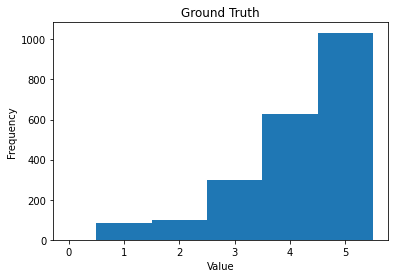

In [0]:
bins_list=[0,0.5,1.5,2.5,3.5,4.5,5.5]
getHistogram('ratingScore', "Ground Truth")
plt.hist(finaldf['ratingScore'].values, bins=bins_list)

(array([  48.,   36.,   37.,   32.,   33.,   32.,   56.,   71.,  171.,
        1624.]),
 array([-0.9827 , -0.78449, -0.58628, -0.38807, -0.18986,  0.00835,
         0.20656,  0.40477,  0.60298,  0.80119,  0.9994 ]),
 <a list of 10 Patch objects>)

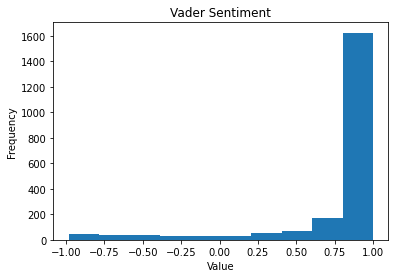

In [0]:
getHistogram('vader', "Vader Sentiment")
plt.hist(finaldf['vader'].values)

About 1650 people rated hotels as 4 and 5 and 1624 have a vedar value greater than 0.994. This distribution generally agree with each other.
####(b) Show a histogram of the number of reviews per hotel. Do you notice any interesting trends? Are these expected?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

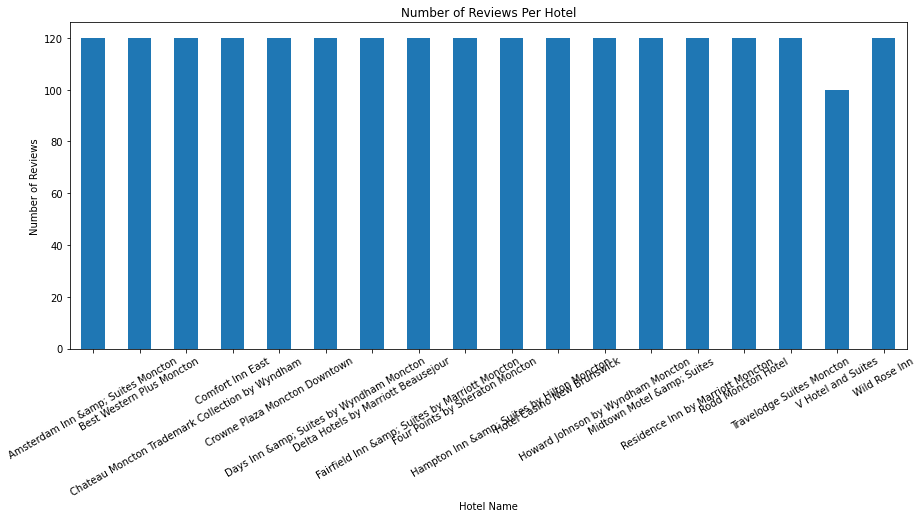

In [0]:
plt.figure(figsize=(15,6))
df2.groupby('hotelName').count().hotelReview.plot(kind='bar')
plt.title("Number of Reviews Per Hotel")
plt.xlabel("Hotel Name")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=30)

I intentionally cut down the size of reviews to 120 for those hotels who have more than 120 reviews and deleted those hotels with few reviews.
###(b) Boxplots
####(a) In two plots, one for ground truth star rating and one for Vader sentiment, show a plot of 5 side-by-side boxplots of these scores.

In [0]:
#Extract a list of hotels
hotelNames = finaldf['hotelName'].unique()
hotelNames
def getHotelRank(df, measure='ratingScore'):
    #Rank the hotel by ground truth rating score
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pandas.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avgRatingScore']
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0)
    return hotelRatingDfGt

In [0]:
hotelRatingDfGt = getHotelRank(finaldf)

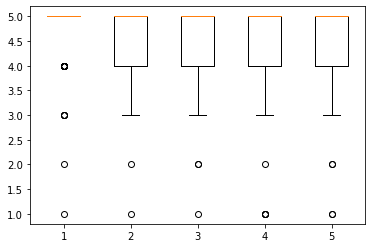

In [0]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].values

hampton = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['ratingScore']
residenceInn = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['ratingScore']
wildRose = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['ratingScore']
fairfield = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['ratingScore']
fourPoints = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['ratingScore']

data = [hampton, residenceInn,wildRose, fairfield,fourPoints]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

In [0]:
tp5gthotel

,hotelName,avgRatingScore
9,Hampton Inn &amp; Suites by Hilton Moncton,4.725000
13,Residence Inn by Marriott Moncton,4.558333
17,Wild Rose Inn,4.558333
7,Fairfield Inn &amp; Suites by Marriott Moncton,4.533333
8,Four Points by Sheraton Moncton,4.483333


In [0]:
hotelRatingDfGt = getHotelRank(finaldf,measure='vader')

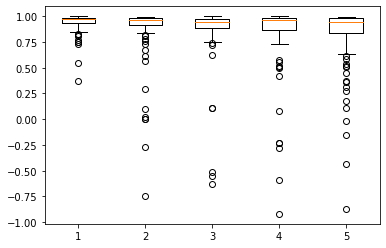

In [0]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].values

wildRose = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['vader']
hampton = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['vader']
residenceInn = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['vader']
chateauMoncton = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['vader']
deltaHotels = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['vader']

data = [wildRose, hampton, residenceInn,chateauMoncton, deltaHotels]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

In [0]:
tp5gthotel

,hotelName,avgRatingScore
17,Wild Rose Inn,0.940159
9,Hampton Inn &amp; Suites by Hilton Moncton,0.877746
13,Residence Inn by Marriott Moncton,0.873703
2,Chateau Moncton Trademark Collection by Wyndham,0.852117
6,Delta Hotels by Marriott Beausejour,0.827642


####(b) Report the mean and variance of the ground truth and Vader sentiment scores for the top-5 ranked hotels according to star rating.

In [0]:
meanGT = pd.DataFrame(df2.groupby('hotelName').ratingScore.mean())
varGT = pd.DataFrame(df2.groupby('hotelName').ratingScore.var())
hotelRatingSore = pd.concat([meanGT, varGT],axis=1,sort=False)
hotelRatingSore.columns = ['mean','variance']

meanV = pd.DataFrame(df2.groupby('hotelName').vader.mean())
varV = pd.DataFrame(df2.groupby('hotelName').vader.var())
hotelVader = pd.concat([meanV, varV],axis=1,sort=False)
hotelVader.columns = ['mean','variance']

In [0]:
#Ground Truth Rating 
hotelRatingSore.sort_values(by=['mean'],ascending=False)

,mean,variance
hotelName,,
Hampton Inn &amp; Suites by Hilton Moncton,4.725000,0.419538
Residence Inn by Marriott Moncton,4.558333,0.517577
Wild Rose Inn,4.558333,0.551190
Fairfield Inn &amp; Suites by Marriott Moncton,4.533333,0.771989
Four Points by Sheraton Moncton,4.483333,0.638375
Chateau Moncton Trademark Collection by Wyndham,4.483333,0.621569
Amsterdam Inn &amp; Suites Moncton,4.450000,0.770588
Delta Hotels by Marriott Beausejour,4.200000,1.001681
Midtown Motel &amp; Suites,4.133333,1.225770


In [0]:
#Vader 
hotelVader.sort_values(by=['mean'],ascending=False)

,mean,variance
hotelName,,
Wild Rose Inn,0.940159,0.007207
Hampton Inn &amp; Suites by Hilton Moncton,0.877746,0.069074
Residence Inn by Marriott Moncton,0.873703,0.069271
Chateau Moncton Trademark Collection by Wyndham,0.852117,0.095723
Delta Hotels by Marriott Beausejour,0.827642,0.087139
Amsterdam Inn &amp; Suites Moncton,0.816495,0.148852
Fairfield Inn &amp; Suites by Marriott Moncton,0.814950,0.115773
Four Points by Sheraton Moncton,0.803104,0.159516
V Hotel and Suites,0.790096,0.138331


The boxplots and the mena and variance are equally informative.
* For ***ground truth rating***
 * Because the difference between the top ranking hotels is very little, the difference of the boxplots for the top five hotels is barely noticeable. The medium for the top 5 hotels are similar. The ground truth rating data for ***Hampton Inn &amp; Suites by Hilton Moncton*** is the most dense around the medium. Other four hotels have similar distribution. 
 *  Mean and variance can tell mroe nuances. Although the mean for the five hotels is similar, ***Hampton Inn &amp; Suites by Hilton Moncton*** ranks the first and has the least variance. ***Fairfield Inn &amp; Suites by Marriott Moncton*** has the most variance amoung the five hotels.
* For ***vader***,
 * The medium for the 5 top ranking hotels is again not very noticeable; however, we can tell the first hotel's vader score is the least scattered whereas the fifth hotel's vade score is the most scattered. 
 * We can easily tell that the first hotel has the greatest mean. The variance of the forth hotel is greater than that of the fifth hotel. 

###(c) Scatterplots and heatmaps
####(a) Show both a scatterplot and heatmap of ground truth score (star rating) versus Vader sentiment score. Each review is a point on the scatterplot.

Text(0.5, 0, 'Vader Score')

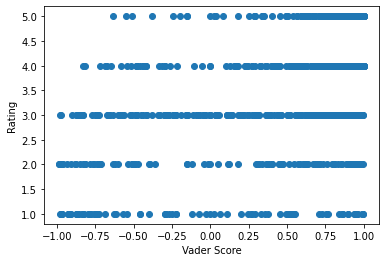

In [0]:
y = finaldf['ratingScore'].values
x = finaldf['vader'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Vader Score')

In [0]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

Text(0, 0.5, 'Rating')

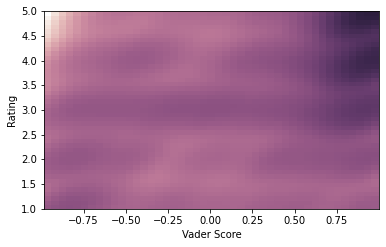

In [0]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
# ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
# ax2.set_xlim(x.min(), x.max())
# ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

# ax2.set_xlabel('Vader Score')
# ax2.set_ylabel('Rating')

* There are a lot of positive ground truth ratings with positive vader. Those data points gather around the top right corner. 
* 3 score rating is neutral in terms of vader. The data points vary acorss the realm of vader. 
* Reviews for low ratings like 1 and 2 are more polarized. Those reviews are either extremely positive or extremely negative. 
* 1 score rating tends to have negative reviews.

####(b) Show two scatterplots and two heatmaps of the length of reviews versus each of ground truth score and Vader sentiment score.

In [0]:
lst=[]
for r in finaldf['reviewCol'].iteritems():
    lst.append(len(r[1].split()))
finaldf['Length'] = lst

Text(0.5, 0, 'Review Length')

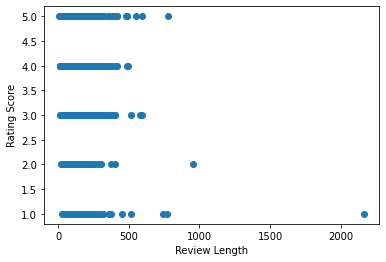

In [120]:
y = finaldf['ratingScore'].values
x = finaldf['Length'].values
plt.plot(x, y,"o")
plt.ylabel('Rating Score')
plt.xlabel('Review Length')

Text(0, 0.5, 'Rating Socre')

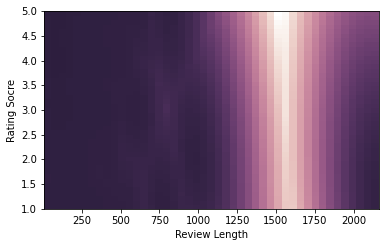

In [121]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#plot
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())

ax1.set_xlabel('Review Length')
ax1.set_ylabel('Rating Socre')

Text(0.5, 0, 'Review Length')

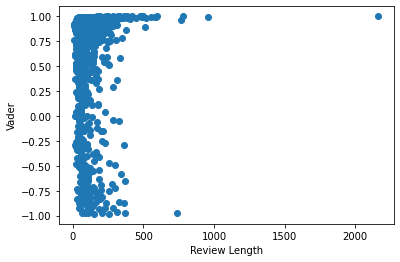

In [122]:
y = finaldf['vader'].values
x = finaldf['Length'].values
plt.plot(x, y,"o")
plt.ylabel('Vader')
plt.xlabel('Review Length')

Text(0, 0.5, 'Vader')

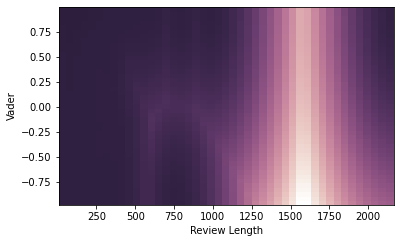

In [123]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#plot
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())

ax1.set_xlabel('Review Length')
ax1.set_ylabel('Vader')

* People's comments generally don't exceed 500 words, which is true for all values of vader. Both extremely high ratings and low ratings tend to have more outliers for review length, possibly because the customer was either too happy or too angry with the service. 
* Vader values in the middle tend to have shorter reviews. Values on the edge tend to have longer reviews. Vader value doesn't necessarily represent the truth. The outlier who rated 1 and wrote more than 2000 words of a story to complain received a high vader. There isn't much words in his review to describe his mood. 

####(c) Show two scatterplots of the number of reviews per hotel versus each of average ground truth score and average Vader sentiment score. In this case, each hotel is a single point on the scatterplot.

In [0]:
reviewNum = finaldf.groupby('hotelName').reviewCol.count()
cDF = pd.concat([hotelRatingSore, reviewNum],axis=1,sort=False)

Text(0.5, 0, 'Number of Reviews')

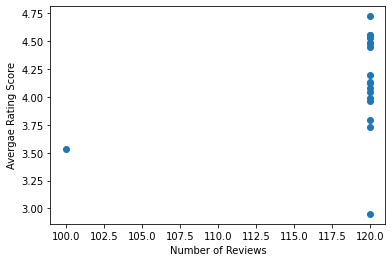

In [153]:
y = cDF['mean'].values
x = cDF['reviewCol'].values
plt.plot(x, y,"o")
plt.ylabel('Avergae Rating Score')
plt.xlabel('Number of Reviews')

In [0]:
reviewNum = finaldf.groupby('hotelName').reviewCol.count()
cDF = pd.concat([hotelVader, reviewNum],axis=1,sort=False)

Text(0.5, 0, 'Number of Reviews')

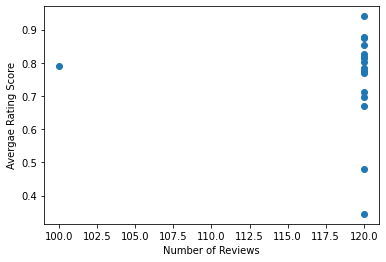

In [155]:
y = cDF['mean'].values
x = cDF['reviewCol'].values
plt.plot(x, y,"o")
plt.ylabel('Avergae Rating Score')
plt.xlabel('Number of Reviews')

Because I intentionally manipulated the data, the number of reviews are almost equal.